# Human Activity Recognition using PyTorch

The goal of this project is to harness PyTorch's capabilities to develop a specialized model capable of accurately identifying and classifying human activities from images. I obtained the dataset from kaggle 'https://www.kaggle.com/datasets/meetnagadia/human-action-recognition-har-dataset'. I worked with the labelled dataset and divided it to train and test set.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import pandas as pd
import os
from PIL import Image
import random
import pickle
import shutil
import torchvision
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from shutil import move
from torchvision import datasets
from tqdm.auto import tqdm
from timeit import default_timer as timer 

In [2]:
# Set device to CUDA if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load and preprocess data
data = pd.read_csv('Training_set.csv')
unique_labels = data['label'].unique()


Create a directory and divide the test images to their corresponding labels

In [4]:
!mkdir labeled_images


In [5]:
output_dir = 'labeled_images'
for label in unique_labels:
    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)

In [6]:
# Move images to labeled directories
input_image_folder = 'train'
for index, row in data.iterrows():
    image_filename = row['filename']
    label = row['label']
    source_path = os.path.join(input_image_folder, image_filename)
    destination_path = os.path.join(output_dir, label, image_filename)
    move(source_path, destination_path)

In [7]:
!mkdir new_train
!mkdir new_test

In [8]:
output_dir = 'new_train'
for label in unique_labels:
    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)


output_dir = 'new_test'
for label in unique_labels:
    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)

In [9]:
train_dir = 'new_train'
test_dir = 'new_test'

original_dir ='labeled_images'

for label in unique_labels:
    label_dir = os.path.join(original_dir, label)
    
    # List all image files in the label directory
    image_files = [f for f in os.listdir(label_dir) if f.endswith('.jpg')]
    
    # Split the image files into train and test sets
    train_files, test_files = train_test_split(image_files, test_size=0.5, random_state=42)
    
    # Move train files to the train directory
    for filename in train_files:
        src = os.path.join(label_dir, filename)
        dest = os.path.join(train_dir, label, filename)
        shutil.move(src, dest)
    
    # Move test files to the test directory
    for filename in test_files:
        src = os.path.join(label_dir, filename)
        dest = os.path.join(test_dir, label, filename)
        shutil.move(src, dest)


In [10]:
# Helper function to walk through directory and display contents
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [11]:
# Display contents of directories
walk_through_dir('new_train')
walk_through_dir('new_test')

There are 15 directories and 0 images in 'new_train'.
There are 0 directories and 420 images in 'new_train\calling'.
There are 0 directories and 420 images in 'new_train\clapping'.
There are 0 directories and 420 images in 'new_train\cycling'.
There are 0 directories and 420 images in 'new_train\dancing'.
There are 0 directories and 420 images in 'new_train\drinking'.
There are 0 directories and 420 images in 'new_train\eating'.
There are 0 directories and 420 images in 'new_train\fighting'.
There are 0 directories and 420 images in 'new_train\hugging'.
There are 0 directories and 420 images in 'new_train\laughing'.
There are 0 directories and 420 images in 'new_train\listening_to_music'.
There are 0 directories and 420 images in 'new_train\running'.
There are 0 directories and 420 images in 'new_train\sitting'.
There are 0 directories and 420 images in 'new_train\sleeping'.
There are 0 directories and 420 images in 'new_train\texting'.
There are 0 directories and 420 images in 'new_tr

The training and testing datasets consist of a total of 420 images.

In [12]:
# Define image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [13]:
# Create training and testing datasets
train_data = datasets.ImageFolder(root='new_train', transform=transform)
test_data = datasets.ImageFolder(root='new_test', transform=transform)

In [14]:
# Print dataset information
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 6300
    Root location: new_train
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 6300
    Root location: new_test
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [15]:
# Get class names and class-to-index dictionary
class_names = train_data.classes
class_dict = train_data.class_to_idx

In [16]:
# Print dataset sizes
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

Number of training samples: 6300
Number of testing samples: 6300


In [17]:
# Access a sample image and label from the dataset
img, label = train_data[0]
img_permute = img.permute(1, 2, 0)

In [18]:
# Display sample image information
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.7725, 0.7725, 0.7725,  ..., 0.6392, 0.6392, 0.6392],
         [0.7725, 0.7725, 0.7725,  ..., 0.6392, 0.6392, 0.6392],
         [0.7725, 0.7725, 0.7725,  ..., 0.6431, 0.6431, 0.6431],
         ...,
         [0.2745, 0.2706, 0.2431,  ..., 0.1608, 0.1412, 0.1412],
         [0.2510, 0.2471, 0.2235,  ..., 0.1608, 0.1490, 0.1490],
         [0.2392, 0.2353, 0.2118,  ..., 0.1608, 0.1529, 0.1529]],

        [[0.7490, 0.7490, 0.7490,  ..., 0.6196, 0.6196, 0.6196],
         [0.7490, 0.7490, 0.7490,  ..., 0.6196, 0.6196, 0.6196],
         [0.7490, 0.7490, 0.7490,  ..., 0.6235, 0.6235, 0.6235],
         ...,
         [0.2235, 0.2196, 0.1922,  ..., 0.1333, 0.1137, 0.1137],
         [0.2000, 0.1961, 0.1725,  ..., 0.1333, 0.1216, 0.1216],
         [0.1882, 0.1843, 0.1608,  ..., 0.1333, 0.1255, 0.1255]],

        [[0.6863, 0.6863, 0.6863,  ..., 0.5333, 0.5333, 0.5333],
         [0.6863, 0.6863, 0.6863,  ..., 0.5333, 0.5333, 0.5333],
         [0.6863, 0.6863, 0.6863,  ..., 0.53

Text(0.5, 1.0, 'calling')

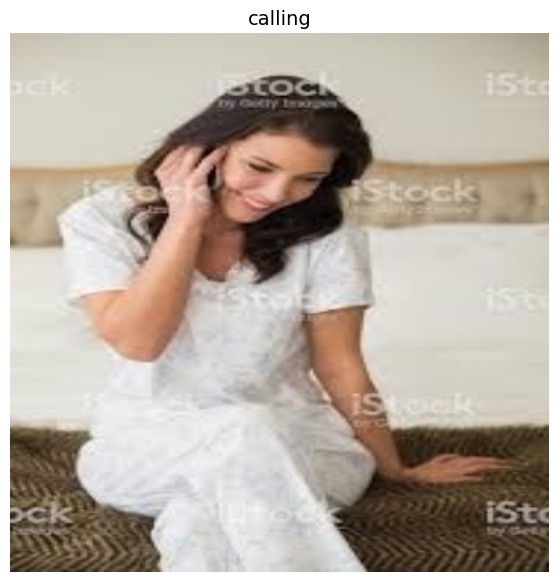

In [19]:
# Transform and display the sample image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [20]:
# Create data loaders for training and testing datasets
train_dataloader = DataLoader(dataset=train_data, batch_size=8, num_workers=2, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=8, num_workers=2, shuffle=False)

In [21]:
# Function to plot original and transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

In [22]:
# Define the number of classes
num_classes = len(data['label'].unique())


In [23]:
# Load pre-trained ResNet50 model with custom final layer
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).to(device)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# Freeze model parameters and modify final layer
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(2048, num_classes)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Function to perform a training step
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [27]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [28]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    prev_train_acc = float('-inf')
    prev_test_acc = float('-inf')

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


         # Check if both training and test accuracies decreased compared to the previous epoch
        if train_acc < prev_train_acc and test_acc < prev_test_acc:
            print("Both training and test accuracies decreased. Stopping training.")
            break
        
        prev_train_acc = train_acc
        prev_test_acc = test_acc

    # 6. Return the filled results at the end of the epochs
    return results

In [29]:
# Measure training time and train the model
start_time = timer()

model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=criterion, 
                        epochs=20)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9118 | train_acc: 0.4059 | test_loss: 1.4633 | test_acc: 0.5584
Epoch: 2 | train_loss: 1.4341 | train_acc: 0.5585 | test_loss: 1.3154 | test_acc: 0.5872
Epoch: 3 | train_loss: 1.2759 | train_acc: 0.6076 | test_loss: 1.2130 | test_acc: 0.6190
Epoch: 4 | train_loss: 1.1848 | train_acc: 0.6405 | test_loss: 1.1992 | test_acc: 0.6148
Epoch: 5 | train_loss: 1.0917 | train_acc: 0.6647 | test_loss: 1.1450 | test_acc: 0.6475
Epoch: 6 | train_loss: 1.0414 | train_acc: 0.6791 | test_loss: 1.1154 | test_acc: 0.6478
Epoch: 7 | train_loss: 0.9833 | train_acc: 0.6931 | test_loss: 1.1483 | test_acc: 0.6382
Epoch: 8 | train_loss: 0.9548 | train_acc: 0.7045 | test_loss: 1.0973 | test_acc: 0.6431
Epoch: 9 | train_loss: 0.9207 | train_acc: 0.7145 | test_loss: 1.0692 | test_acc: 0.6539
Epoch: 10 | train_loss: 0.8829 | train_acc: 0.7308 | test_loss: 1.0642 | test_acc: 0.6591
Epoch: 11 | train_loss: 0.8601 | train_acc: 0.7343 | test_loss: 1.0723 | test_acc: 0.6569
Epoch: 12 | train_l

### Model Training and Evaluation Results

In the provided result, after the 20th epoch:
- The training loss is 0.6915, indicating that the model's predictions on the training dataset have gradually aligned with the actual labels.
- The training accuracy stands at 0.7939, implying that around 79.39% of the training dataset's labels have been predicted correctly.
- The testing loss is 1.0619, suggesting that the model's performance on unseen data might not be as optimal as on the training data.
- The testing accuracy is 0.6645, signifying that approximately 66.45% of the testing dataset's labels have been predicted accurately.

In [30]:
# Plot loss and accuracy curves
def plot_loss_curves(results):
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(results['train_loss'])), results['train_loss'], label='train_loss')
    plt.plot(range(len(results['test_loss'])), results['test_loss'], label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(len(results['train_acc'])), results['train_acc'], label='train_accuracy')
    plt.plot(range(len(results['test_acc'])), results['test_acc'], label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()


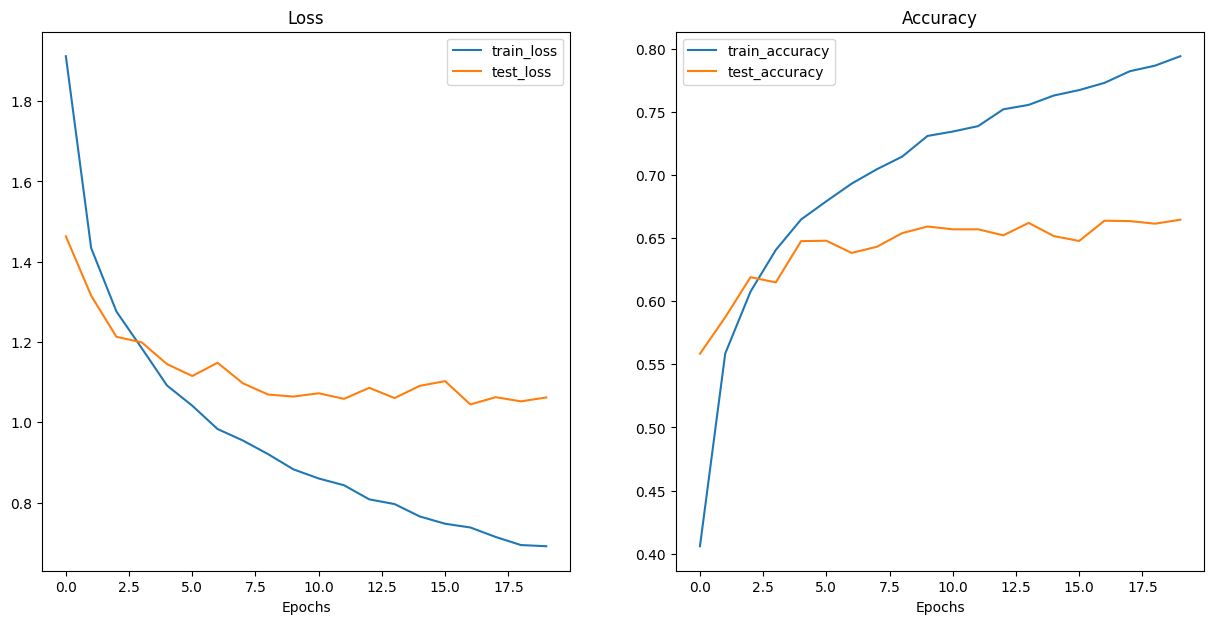

In [31]:
# Plot loss and accuracy curves
plot_loss_curves(model_results)

In [32]:
# Save the trained model using pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Using the Model for Image Prediction

I leveraged the trained model to make predictions on custom images and see if it can bring accurate results. 

In [34]:
# Load in a custom image and convert the tensor values to float32
custom_image_path = 'train/Image_172.jpg'
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.1490, 0.1686, 0.0902,  ..., 0.4667, 0.4667, 0.4627],
         [0.1490, 0.1686, 0.0902,  ..., 0.4706, 0.4667, 0.4667],
         [0.1490, 0.1686, 0.0902,  ..., 0.4745, 0.4745, 0.4706],
         ...,
         [0.2157, 0.2196, 0.2235,  ..., 0.2510, 0.2549, 0.2588],
         [0.2157, 0.2157, 0.2235,  ..., 0.2510, 0.2549, 0.2588],
         [0.2118, 0.2157, 0.2196,  ..., 0.2314, 0.2353, 0.2392]],

        [[0.1412, 0.1608, 0.0902,  ..., 0.4392, 0.4392, 0.4353],
         [0.1412, 0.1608, 0.0902,  ..., 0.4431, 0.4392, 0.4392],
         [0.1412, 0.1608, 0.0902,  ..., 0.4471, 0.4471, 0.4431],
         ...,
         [0.2196, 0.2235, 0.2275,  ..., 0.2627, 0.2667, 0.2706],
         [0.2196, 0.2196, 0.2275,  ..., 0.2627, 0.2667, 0.2706],
         [0.2157, 0.2196, 0.2235,  ..., 0.2431, 0.2471, 0.2510]],

        [[0.0902, 0.1137, 0.0510,  ..., 0.3765, 0.3765, 0.3725],
         [0.0902, 0.1137, 0.0510,  ..., 0.3804, 0.3765, 0.3765],
         [0.0902, 0.1137, 0.0510,  ..

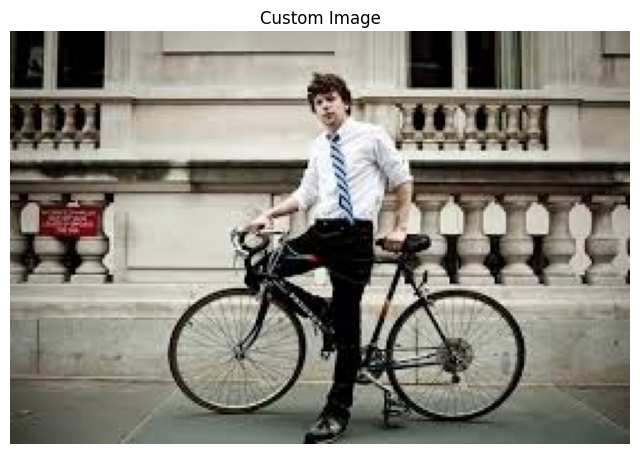

In [44]:
# Convert the PyTorch tensor to a NumPy array for display
custom_image_np = custom_image.numpy()

# Display the custom image
plt.figure(figsize=(8, 8))
plt.imshow(custom_image_np.transpose(1, 2, 0))  # Transpose the dimensions for display
plt.axis("off")
plt.title("Custom Image")
plt.show()

In [38]:
# Apply image transformation to match model requirements
custom_image_transform = transforms.Compose([
    transforms.Resize((512, 512), antialias= True)
])
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape after transformation
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 183, 275])
New shape: torch.Size([3, 512, 512])


In [39]:
# Evaluate the model in inference mode and make a prediction
model.eval()
with torch.inference_mode():
    # Add an extra dimension to the image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on the image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 512, 512])
Unsqueezed custom image shape: torch.Size([1, 3, 512, 512])


In [40]:
# Print the prediction logits
print(f"Prediction logits: {custom_image_pred}")

Prediction logits: tensor([[-5.4597, -8.4814,  1.8894, -8.1335, -5.5633, -7.7328, -8.1156, -7.8233,
         -6.7863, -7.1693, -5.7272, -3.1319, -6.1723, -6.1457, -5.4562]],
       device='cuda:0')


In [41]:
# Convert logits to prediction probabilities using torch.softmax() for multi-class classification
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities to prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction probabilities: tensor([[6.3671e-04, 3.1019e-05, 9.8997e-01, 4.3927e-05, 5.7407e-04, 6.5578e-05,
         4.4720e-05, 5.9900e-05, 1.6897e-04, 1.1521e-04, 4.8726e-04, 6.5294e-03,
         3.1221e-04, 3.2063e-04, 6.3893e-04]], device='cuda:0')
Prediction label: tensor([2], device='cuda:0')


In [42]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
print(f"Predicted class: {custom_image_pred_class}")


Predicted class: cycling


In this scenario, the model successfully made an accurate prediction by correctly assigning the appropriate label to the image.

In [43]:
# Display the prediction probabilities
custom_image_pred_probs

tensor([[6.3671e-04, 3.1019e-05, 9.8997e-01, 4.3927e-05, 5.7407e-04, 6.5578e-05,
         4.4720e-05, 5.9900e-05, 1.6897e-04, 1.1521e-04, 4.8726e-04, 6.5294e-03,
         3.1221e-04, 3.2063e-04, 6.3893e-04]], device='cuda:0')

## Conclusion

By integrating PyTorch's computational power with advanced computer vision techniques, machines gain the capacity to not only comprehend but also interpret human actions through the use of machine learning methods.